In [0]:
from google.colab import drive
drive.mount('/content/drive')




Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
[Errno 2] No such file or directory: 'weights'
/content


In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


0it [00:00, ?it/s]

100%|█████████▉| 170385408/170498071 [00:12<00:00, 16691722.63it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'horse','ship', 'truck'}

background_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog'}

# print(type(foreground_classes))

In [0]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

170500096it [00:30, 16691722.63it/s]                               

In [0]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

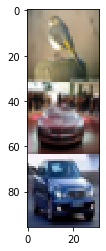

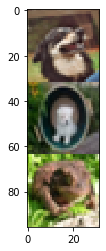

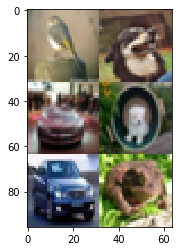

torch.Size([3, 96, 32])


In [0]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)



8


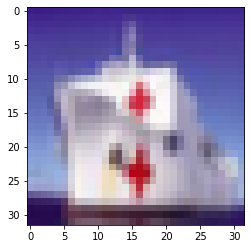

ship


In [0]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]+7]) # add 7 as we had subtracted 7 while saving

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, z):
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x,y = x.to("cuda"),y.to("cuda")
    for i in range(9):
      x[:,i] = self.helper(z[:,i])[:,0]
    x = F.softmax(x,dim=1)   # alphas
    
    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
    return y , x 
  
  def helper(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x
      


In [0]:
 class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,y):  #z batch of list of 9 images
    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.view(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 


In [0]:
where_net = Module1().double()
where_net = where_net.to("cuda")
# print(net.parameters)

In [0]:
# idx = np.random.randint(0,250,10)
# train_iter = iter(train_loader)
# images,labels,_=train_iter.next()

# for i in idx:
#   imshow(where_net1(images)[i].detach().numpy())

In [0]:
what_net = Module2().double()
what_net = what_net.to("cuda")

In [0]:
# where_net.load_state_dict(torch.load("model_epoch90.pt"))
# what_net.load_state_dict(torch.load("model_epoch90.pt"))
# print(fore_net.parameters)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [0]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [69]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where_net.parameters(), lr=0.01, momentum=0.9)
optimizer_what = optim.SGD(what_net.parameters(), lr=0.01, momentum=0.9)

nos_epochs = 180
every_what_epoch = 5
#---------------------------------------------
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0
argmax_more_than_half = 0
argmax_less_than_half =0
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]
#-----------------------------------------------
train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times
    
  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  batch_correct = 0.0
  cnt=0
  total=0
  iteration = desired_num // batch



  #training data set

  if (epoch % (every_what_epoch*2) ) < every_what_epoch :
      print(epoch,"updating what_net, where_net is freezed")
  elif (epoch % (every_what_epoch*2)) > every_what_epoch :
      print(epoch,"updating where_net, what_net is freezed")
    
  for i, data in  enumerate(train_loader):
      inputs , labels , fore_idx = data
      inputs,labels = inputs.to("cuda"),labels.to("cuda") 
      # zero the parameter gradients
      
      optimizer_what.zero_grad()
      optimizer_where.zero_grad()
      
      avg_images , alphas = where_net(inputs)
      outputs = what_net(avg_images)
      
      _, predicted = torch.max(outputs.data, 1)
      

      loss = criterion(outputs, labels) 
      loss.backward() 
  
      if (epoch % (every_what_epoch*2) ) < every_what_epoch :
          optimizer_what.step()
      elif (epoch % (every_what_epoch*2)) > every_what_epoch :
          optimizer_where.step()
      batch_correct += sum(predicted == labels)
      total += len(predicted)
      running_loss += loss.item()
      if cnt % 120 == 119:    # print every 40 mini-batches
          print("--"*40)
          print("Epoch: ",epoch)
#             print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 120))
          train_loss.append(running_loss/120)
          train_acc.append(batch_correct.item()/desired_num)
          print("total_Correct:",batch_correct.item(),"Total:",total,"train_loss",running_loss/120,"train_acc: ", batch_correct.item()/total)
          #running_loss = 0.0
      cnt=cnt+1

      if epoch % 5 == 0:
        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1

  if epoch % 5 == 0:
    col1.append(epoch)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
  
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0
      argmax_more_than_half = 0
      argmax_less_than_half =0

      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
          
      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)

    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)

  elif epoch % 5 != 0  :
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)
 
    
  if (epoch % (every_what_epoch*2) == every_what_epoch*2 - 1):
      torch.save(where_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_180_every5epochs_lr_01/where_model_at_epoch"+str(epoch)+".pt")
      torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_180_every5epochs_lr_01/what_model_at_epoch"+str(epoch)+".pt")
    
print('Finished Training')
torch.save(where_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_180_every5epochs_lr_01/full_where_model_epoch"+str(nos_epochs)+".pt")
torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_180_every5epochs_lr_01/full_what_model_epoch"+str(nos_epochs)+".pt")

0 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
Epoch:  0
total_Correct: 9939.0 Total: 30000 train_loss 1.1028047167914465 train_acc:  0.3313
total_Correct: 3368.0 Total: 10000 test loss:  1.098580671785658 test accuracy 0.3368
1 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
Epoch:  1
total_Correct: 9937.0 Total: 30000 train_loss 1.0987122228032151 train_acc:  0.3312333333333333
total_Correct: 3372.0 Total: 10000 test loss:  1.0986078211333654 test accuracy 0.3372
2 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
Epoch:  2
total_Correct: 9921.0 Total: 30000 train_loss 1.0986772947605392 train_acc:  0.3307
total_Correct: 3260.0 Total: 10000 test loss:  1.09869830838034 test accuracy 0.326
3 updating what_net, where_net is freezed
--------------------------------------

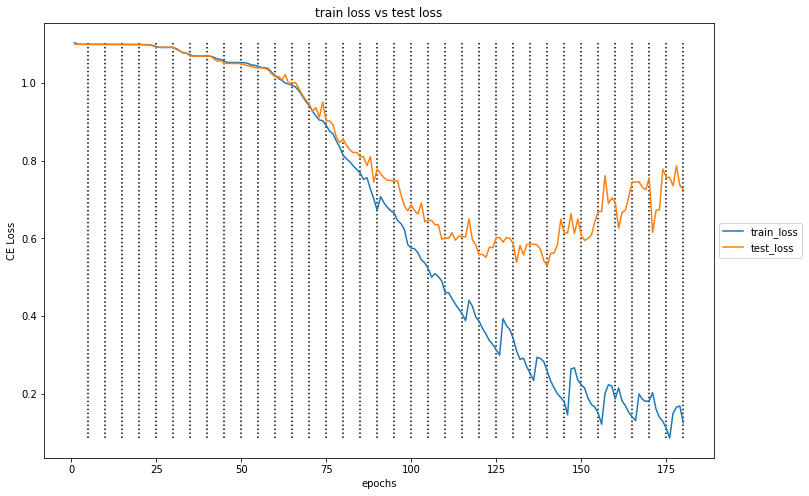

In [70]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_loss = np.random.randn(340)
# test_loss = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_loss, label='train_loss')
plt.plot(epoch_list,test_loss, label='test_loss')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("CE Loss")
plt.vlines(vline_list,min(min(train_loss),min(test_loss)), max(max(test_loss),max(train_loss)),linestyles='dotted')
plt.title("train loss vs test loss")
plt.show()
fig.savefig("train_test_loss_plot.pdf")


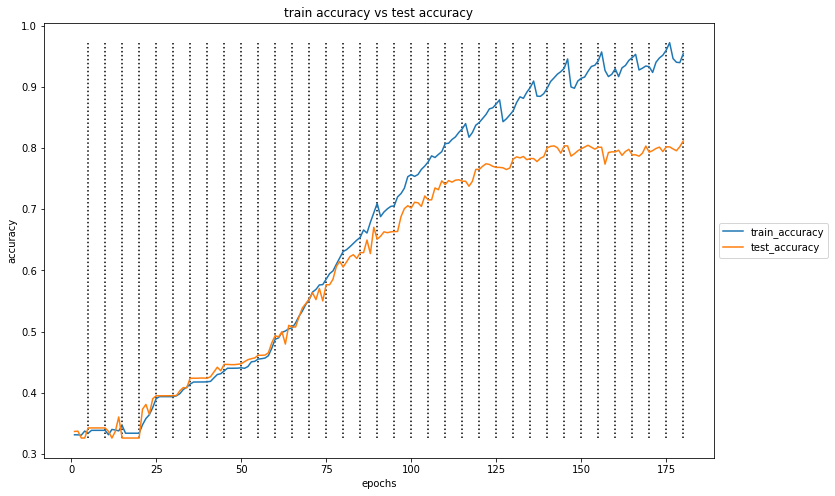

In [71]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_acc = np.random.randn(340)
# test_acc = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_acc, label='train_accuracy')
plt.plot(epoch_list,test_acc, label='test_accuracy')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.vlines(vline_list,min(min(train_acc),min(test_acc)), max(max(test_acc),max(train_acc)),linestyles='dotted')
plt.title("train accuracy vs test accuracy")
plt.show()
fig.savefig("train_test_acc_plot.pdf")

In [0]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [73]:
df_train

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        0             0  ...                   1636                   18425
1        5             0  ...                   1522                   18321
2       10             0  ...                   1542                   18516
3       15             0  ...                   1687                   18297
4       20             0  ...                   1556                   18016
5       25             0  ...                   1288                   16903
6       30             0  ...                   1370                   16779
7       35             0  ...                   1335                   16140
8       40             0  ...                   2112                   15330
9       45             0  ...                   2115                   14682
10      50             0  ...                   4537                   12265
11      55             0  ...                   4473                   11858
12      60             0  ...                   3974                   11339
13      65             0  ...                   3350                   11228
14      70          5021  ...                   2930                   10135
15      75          5021  ...                   2388                    9778
16      80         11287  ...                   2577                    8410
17      85         11287  ...                   1974                    8047
18      90         12339  ...                   2244                    7123
19      95         12339  ...                   1736                    6664
20     100         18712  ...                   1637                    5760
21     105         18712  ...                   1167                    5222
22     110         19927  ...                   1268                    4503
23     115         19927  ...                    881                    3927
24     120         20217  ...                   1003                    3556
25     125         20217  ...                    651                    2994
26     130         22066  ...                    754                    3021
27     135         22066  ...                    431                    2292
28     140         22480  ...                    577                    2166
29     145         22480  ...                    244                    1394
30     150         21397  ...                    557                    1970
31     155         21397  ...                    191                    1104
32     160         20120  ...                    573                    1932
33     165         20120  ...                    314                    1099
34     170         21014  ...                    604                    1697
35     175         21014  ...                    145                     697

[36 rows x 7 columns]

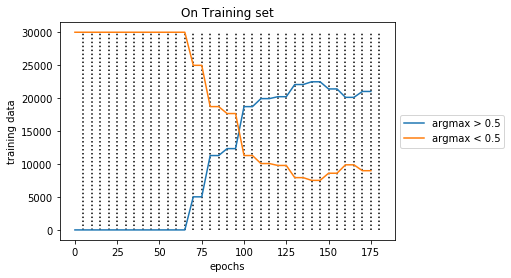

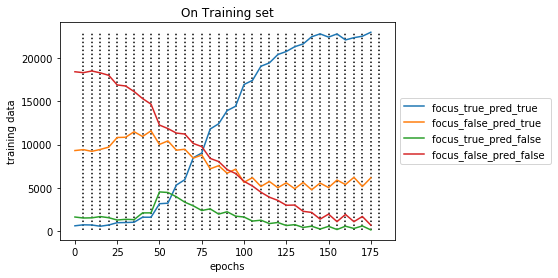

In [74]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.vlines(vline_list,min(min(col2),min(col3)), max(max(col2),max(col3)),linestyles='dotted')
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.vlines(vline_list,min(min(col4),min(col5),min(col6),min(col7)), max(max(col4),max(col5),max(col6),max(col7)),linestyles='dotted')
plt.show()

In [75]:
df_test

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        0             0  ...                    501                    6131
1        5             0  ...                    503                    6072
2       10             0  ...                    500                    6132
3       15             0  ...                    534                    6206
4       20             0  ...                    452                    5817
5       25             0  ...                    437                    5613
6       30             0  ...                    440                    5605
7       35             0  ...                    427                    5335
8       40             0  ...                    750                    4988
9       45             0  ...                    695                    4842
10      50             0  ...                   1490                    4002
11      55             0  ...                   1507                    3881
12      60             0  ...                   1226                    3862
13      65             0  ...                   1133                    3793
14      70          1656  ...                    972                    3396
15      75          1656  ...                    824                    3412
16      80          3656  ...                    853                    3010
17      85          3656  ...                    725                    2986
18      90          4010  ...                    772                    2671
19      95          4010  ...                    694                    2672
20     100          6038  ...                    633                    2255
21     105          6038  ...                    557                    2291
22     110          6431  ...                    565                    1969
23     115          6431  ...                    533                    2011
24     120          6463  ...                    492                    1808
25     125          6463  ...                    495                    1823
26     130          7014  ...                    464                    1682
27     135          7014  ...                    465                    1709
28     140          7044  ...                    453                    1521
29     145          7044  ...                    449                    1518
30     150          6684  ...                    455                    1531
31     155          6684  ...                    458                    1531
32     160          6322  ...                    450                    1588
33     165          6322  ...                    537                    1576
34     170          6579  ...                    526                    1518
35     175          6579  ...                    483                    1500

[36 rows x 7 columns]

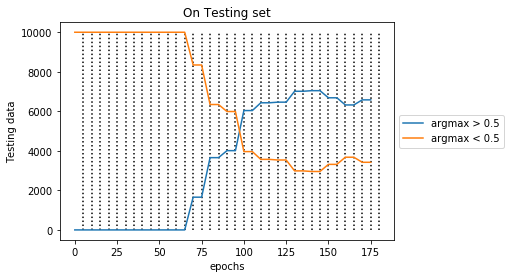

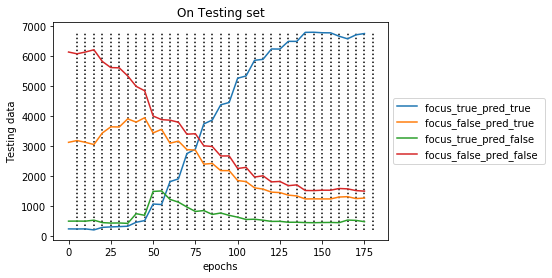

In [76]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.vlines(vline_list,min(min(col8),min(col9)), max(max(col8),max(col9)),linestyles='dotted')
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.vlines(vline_list,min(min(col10),min(col11),min(col12),min(col13)), max(max(col10),max(col11),max(col12),max(col13)),linestyles='dotted')
plt.show()

In [77]:
print("-"*20,"Training Dataset","-"*20)
print("epochs", col1) 
print("argmax > 0.5 ", col2) 
print("argmax < 0.5 ", col3) 
print("focus_true_pred_true", col4) 
print("focus_false_pred_true", col5)
print("focus_true_pred_false", col6) 
print("focus_false_pred_false", col7) 
print("-"*20,"Testing Dataset","-"*20)
print("argmax > 0.5 ", col8)
print("argmax < 0.5", col9) 
print("focus_true_pred_true", col10) 
print("focus_false_pred_true", col11)
print("focus_true_pred_false", col12) 
print("focus_false_pred_false", col13) 

-------------------- Training Dataset --------------------
epochs [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175]
argmax > 0.5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5021, 5021, 11287, 11287, 12339, 12339, 18712, 18712, 19927, 19927, 20217, 20217, 22066, 22066, 22480, 22480, 21397, 21397, 20120, 20120, 21014, 21014]
argmax < 0.5  [30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 24979, 24979, 18713, 18713, 17661, 17661, 11288, 11288, 10073, 10073, 9783, 9783, 7934, 7934, 7520, 7520, 8603, 8603, 9880, 9880, 8986, 8986]
focus_true_pred_true [620, 734, 715, 570, 712, 980, 998, 1033, 1613, 1610, 3171, 3235, 5329, 5953, 8490, 9032, 11808, 12411, 13929, 14437, 16956, 17426, 19063, 19450, 20415, 20767, 21319, 21642, 22471, 22804, 22431, 22797, 22106, 22365, 22534, 22993]
focus_false_pred_true [9319, 9423, 9227, 9446, 9716, 10829, 

In [0]:
df_train.to_csv("/content/drive/My Drive/Research/stage_wise_training/alternate_training_180_every5epochs_lr_01/focus_vs_predicted_train.csv")
df_test.to_csv("/content/drive/My Drive/Research/stage_wise_training/alternate_training_180_every5epochs_lr_01/focus_vs_predicted_test.csv")

In [0]:
def display(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

****************************************************************************************************


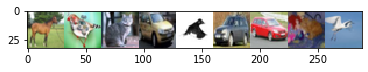

tensor([0.6200, 0.0582, 0.0136, 0.0495, 0.0023, 0.0047, 0.0377, 0.2001, 0.0139],
       device='cuda:0', dtype=torch.float64)


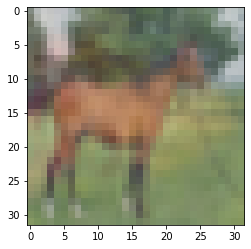

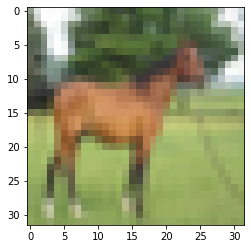

predicted horse
true horse
****************************************************************************************************


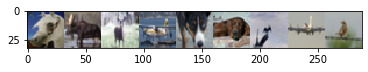

tensor([0.0511, 0.0316, 0.1137, 0.1265, 0.0141, 0.0163, 0.0611, 0.4830, 0.1026],
       device='cuda:0', dtype=torch.float64)


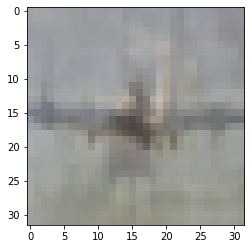

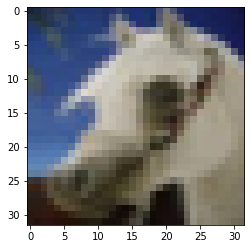

predicted horse
true horse
****************************************************************************************************


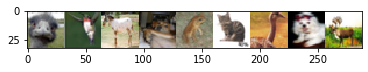

tensor([0.3130, 0.0537, 0.1055, 0.1104, 0.1887, 0.0436, 0.0390, 0.0244, 0.1216],
       device='cuda:0', dtype=torch.float64)


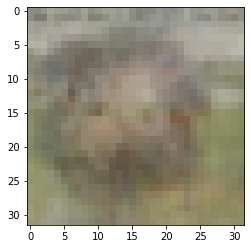

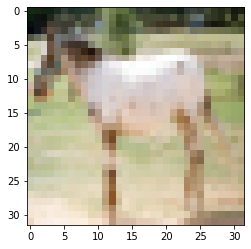

predicted horse
true horse
****************************************************************************************************


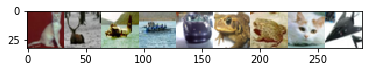

tensor([0.0593, 0.0638, 0.0559, 0.0908, 0.3415, 0.2124, 0.0181, 0.0431, 0.1150],
       device='cuda:0', dtype=torch.float64)


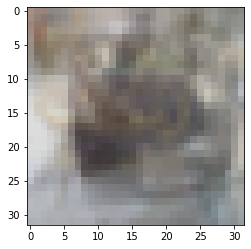

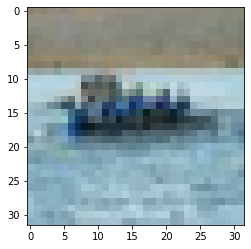

predicted ship
true ship
****************************************************************************************************


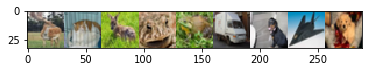

tensor([0.1027, 0.2575, 0.0087, 0.2037, 0.0304, 0.1201, 0.0306, 0.2197, 0.0266],
       device='cuda:0', dtype=torch.float64)


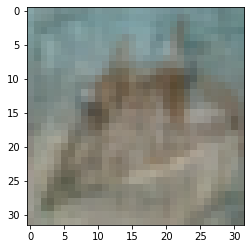

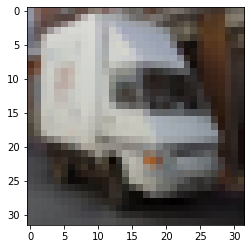

predicted truck
true truck
****************************************************************************************************


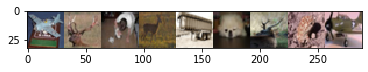

tensor([0.0910, 0.0085, 0.0028, 0.0064, 0.8640, 0.0018, 0.0035, 0.0073, 0.0148],
       device='cuda:0', dtype=torch.float64)


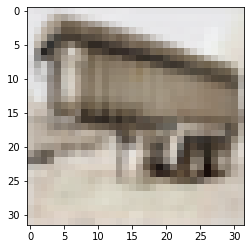

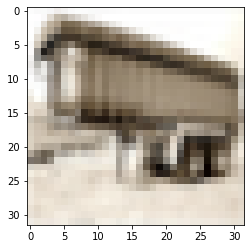

predicted truck
true truck
****************************************************************************************************


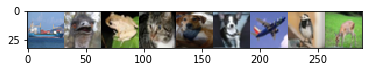

tensor([0.4847, 0.1851, 0.0279, 0.0337, 0.0403, 0.1470, 0.0191, 0.0367, 0.0255],
       device='cuda:0', dtype=torch.float64)


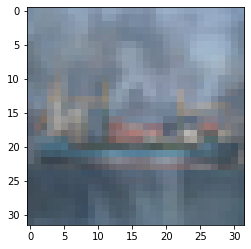

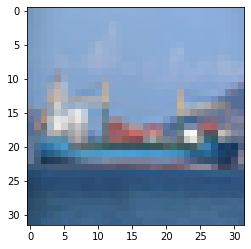

predicted ship
true ship
****************************************************************************************************


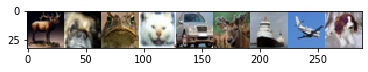

tensor([8.7633e-02, 2.7263e-02, 1.0794e-02, 1.2213e-02, 1.0366e-02, 7.9662e-03,
        8.4278e-01, 1.6242e-04, 8.2430e-04], device='cuda:0',
       dtype=torch.float64)


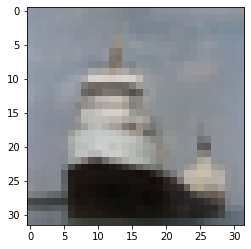

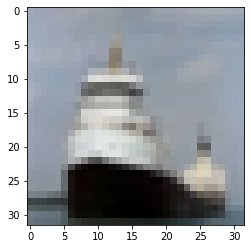

predicted ship
true ship
****************************************************************************************************


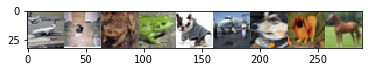

tensor([0.0182, 0.0029, 0.0064, 0.0021, 0.0026, 0.0837, 0.0117, 0.0091, 0.8632],
       device='cuda:0', dtype=torch.float64)


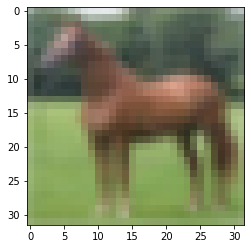

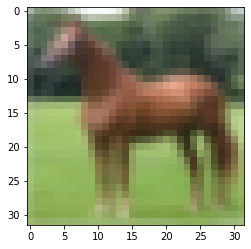

predicted horse
true horse
****************************************************************************************************


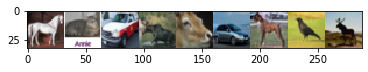

tensor([7.6513e-03, 4.2112e-04, 8.9578e-05, 3.2244e-04, 1.6369e-04, 6.0573e-04,
        9.9023e-01, 6.6680e-05, 4.4534e-04], device='cuda:0',
       dtype=torch.float64)


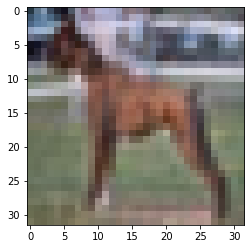

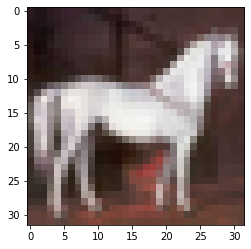

predicted horse
true horse
****************************************************************************************************


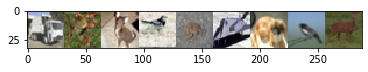

tensor([0.8588, 0.0041, 0.0099, 0.0018, 0.0281, 0.0249, 0.0096, 0.0383, 0.0245],
       device='cuda:0', dtype=torch.float64)


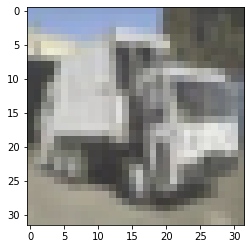

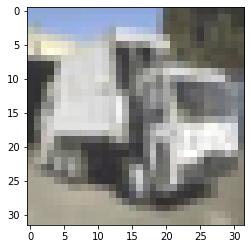

predicted truck
true truck
****************************************************************************************************


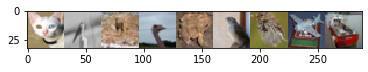

tensor([0.0074, 0.2264, 0.0318, 0.0072, 0.0052, 0.0132, 0.0064, 0.2726, 0.4297],
       device='cuda:0', dtype=torch.float64)


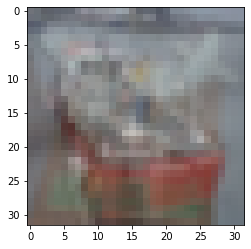

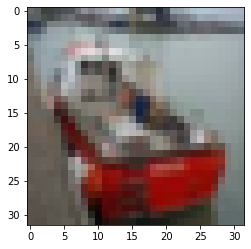

predicted ship
true ship
****************************************************************************************************


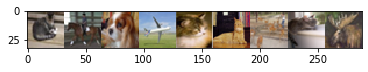

tensor([0.0736, 0.1458, 0.0115, 0.4936, 0.0469, 0.0875, 0.0393, 0.0695, 0.0324],
       device='cuda:0', dtype=torch.float64)


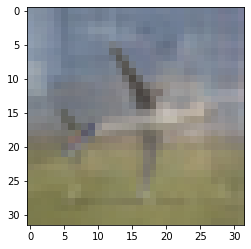

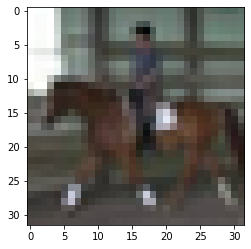

predicted horse
true horse
****************************************************************************************************


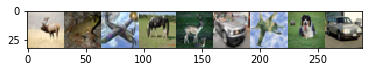

tensor([0.0269, 0.0146, 0.0013, 0.8150, 0.0103, 0.0411, 0.0067, 0.0158, 0.0683],
       device='cuda:0', dtype=torch.float64)


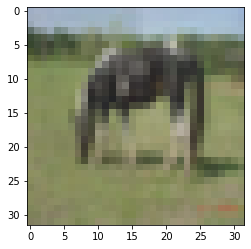

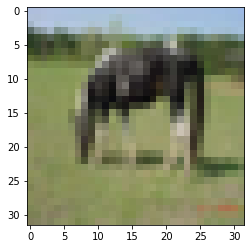

predicted horse
true horse
****************************************************************************************************


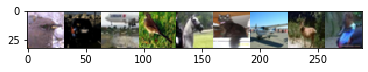

tensor([0.0959, 0.0383, 0.5369, 0.0463, 0.0222, 0.0046, 0.2428, 0.0104, 0.0026],
       device='cuda:0', dtype=torch.float64)


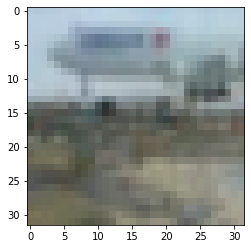

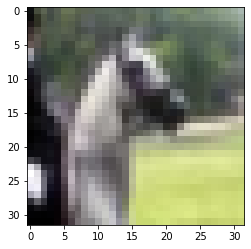

predicted horse
true horse
****************************************************************************************************


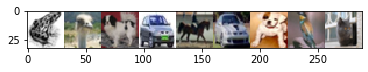

tensor([0.0315, 0.0677, 0.0053, 0.0033, 0.7351, 0.0865, 0.0047, 0.0217, 0.0441],
       device='cuda:0', dtype=torch.float64)


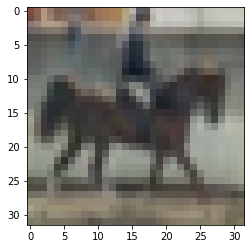

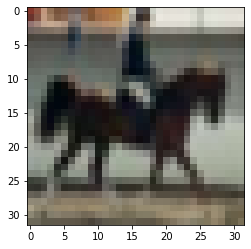

predicted horse
true horse
****************************************************************************************************


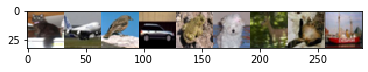

tensor([4.8823e-04, 2.8616e-03, 6.6298e-03, 3.2085e-03, 6.9548e-03, 5.6977e-03,
        4.3173e-03, 5.0033e-03, 9.6484e-01], device='cuda:0',
       dtype=torch.float64)


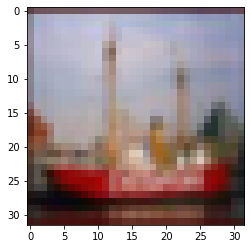

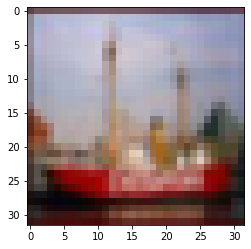

predicted ship
true ship
****************************************************************************************************


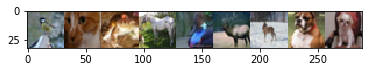

tensor([1.1767e-02, 9.2977e-03, 1.8806e-02, 9.2797e-01, 6.6118e-04, 7.8454e-03,
        8.5887e-03, 1.0490e-02, 4.5757e-03], device='cuda:0',
       dtype=torch.float64)


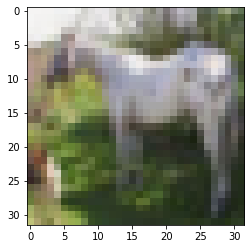

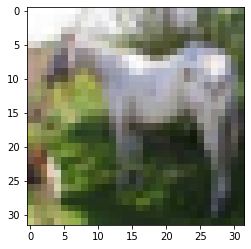

predicted horse
true horse
****************************************************************************************************


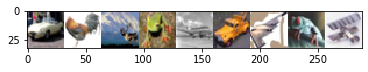

tensor([0.0205, 0.0142, 0.0849, 0.0122, 0.2190, 0.2447, 0.0022, 0.1810, 0.2215],
       device='cuda:0', dtype=torch.float64)


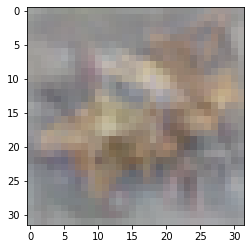

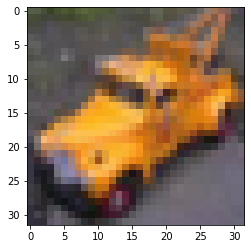

predicted ship
true truck
****************************************************************************************************


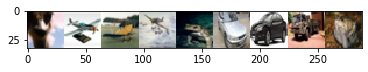

tensor([0.0124, 0.0318, 0.3911, 0.0933, 0.1869, 0.0777, 0.0256, 0.1277, 0.0535],
       device='cuda:0', dtype=torch.float64)


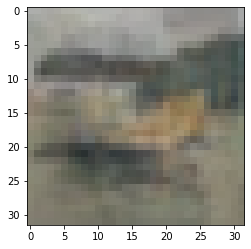

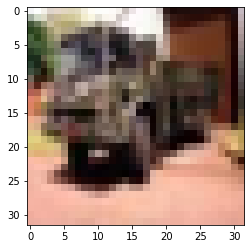

predicted truck
true truck
****************************************************************************************************


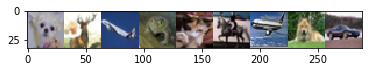

tensor([1.0155e-03, 5.4002e-03, 3.6115e-04, 2.0367e-03, 3.0012e-03, 9.8127e-01,
        1.7202e-03, 2.0174e-03, 3.1735e-03], device='cuda:0',
       dtype=torch.float64)


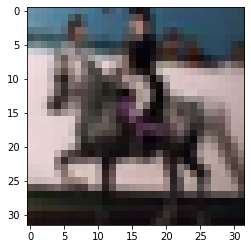

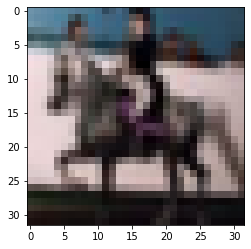

predicted horse
true horse
****************************************************************************************************


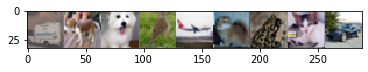

tensor([0.3982, 0.0388, 0.0259, 0.0197, 0.0840, 0.2881, 0.0787, 0.0387, 0.0280],
       device='cuda:0', dtype=torch.float64)


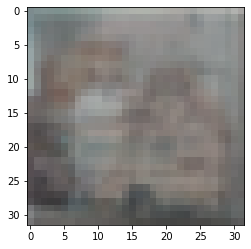

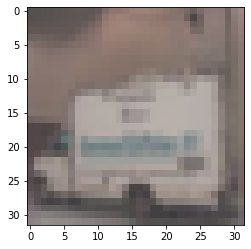

predicted truck
true truck
****************************************************************************************************


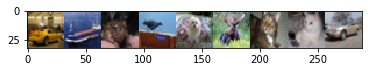

tensor([0.0152, 0.5684, 0.0330, 0.0470, 0.1457, 0.0605, 0.0066, 0.0255, 0.0981],
       device='cuda:0', dtype=torch.float64)


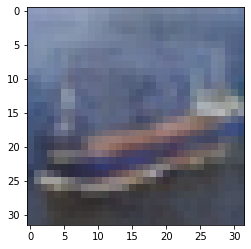

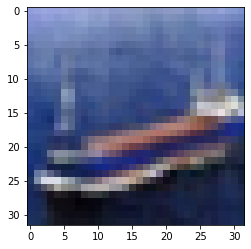

predicted ship
true ship
****************************************************************************************************


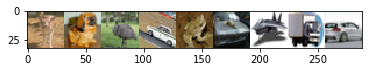

tensor([5.0017e-03, 1.8400e-02, 1.1751e-02, 2.6319e-03, 1.3423e-04, 2.4633e-02,
        8.2718e-03, 9.2715e-01, 2.0284e-03], device='cuda:0',
       dtype=torch.float64)


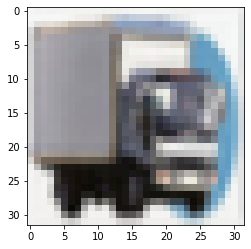

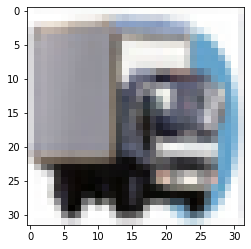

predicted truck
true truck
****************************************************************************************************


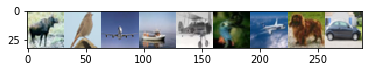

tensor([0.0141, 0.0608, 0.0168, 0.5103, 0.1379, 0.0589, 0.1253, 0.0511, 0.0247],
       device='cuda:0', dtype=torch.float64)


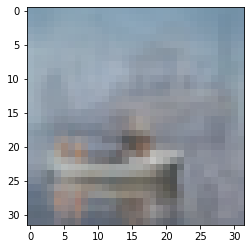

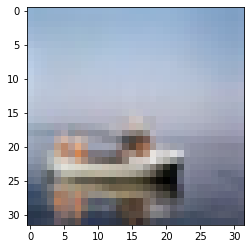

predicted ship
true ship
****************************************************************************************************


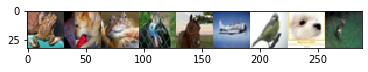

tensor([0.0160, 0.0036, 0.0871, 0.0622, 0.6938, 0.0560, 0.0169, 0.0102, 0.0542],
       device='cuda:0', dtype=torch.float64)


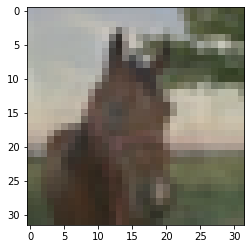

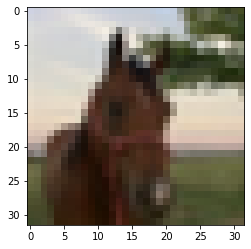

predicted horse
true horse
****************************************************************************************************


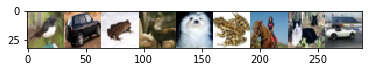

tensor([6.5944e-03, 3.0712e-02, 1.4292e-02, 5.8232e-02, 5.8193e-04, 2.9134e-02,
        8.2403e-01, 2.4992e-02, 1.1429e-02], device='cuda:0',
       dtype=torch.float64)


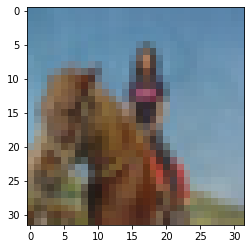

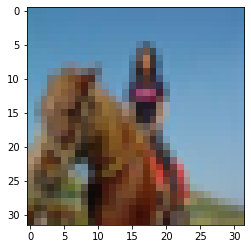

predicted horse
true horse
****************************************************************************************************


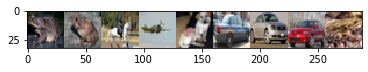

tensor([0.0059, 0.0059, 0.8422, 0.0187, 0.0631, 0.0111, 0.0410, 0.0026, 0.0095],
       device='cuda:0', dtype=torch.float64)


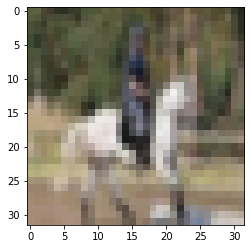

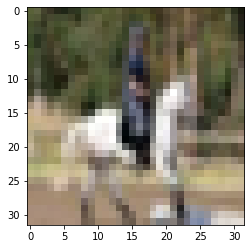

predicted horse
true horse
****************************************************************************************************


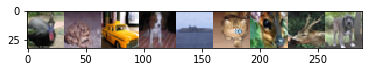

tensor([0.1333, 0.1530, 0.0090, 0.0219, 0.2728, 0.0479, 0.0552, 0.1106, 0.1963],
       device='cuda:0', dtype=torch.float64)


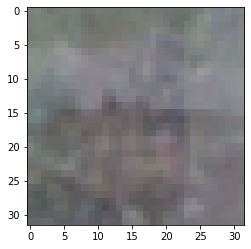

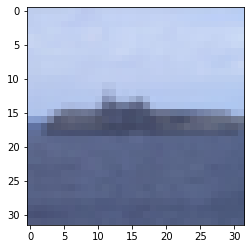

predicted ship
true ship
****************************************************************************************************


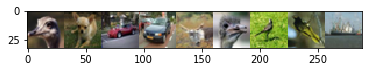

tensor([6.0486e-03, 2.2411e-03, 8.5206e-04, 1.2136e-03, 5.0033e-03, 4.2189e-03,
        4.3042e-04, 2.8262e-03, 9.7717e-01], device='cuda:0',
       dtype=torch.float64)


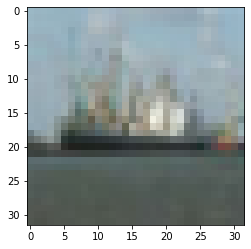

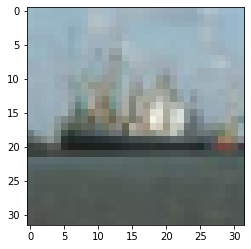

predicted ship
true ship
****************************************************************************************************


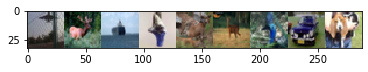

tensor([0.3852, 0.0176, 0.3463, 0.0325, 0.0944, 0.0545, 0.0254, 0.0180, 0.0262],
       device='cuda:0', dtype=torch.float64)


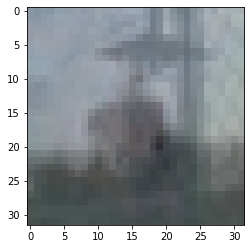

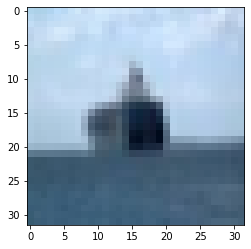

predicted ship
true ship
****************************************************************************************************


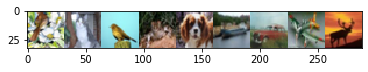

tensor([0.0143, 0.0190, 0.1195, 0.0359, 0.0734, 0.2261, 0.4605, 0.0413, 0.0098],
       device='cuda:0', dtype=torch.float64)


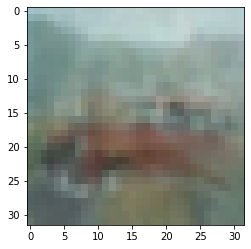

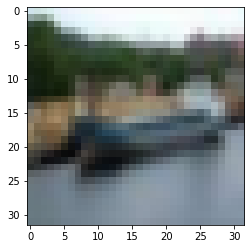

predicted ship
true ship
****************************************************************************************************


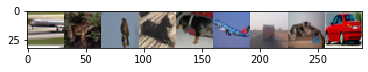

tensor([0.0231, 0.0221, 0.0639, 0.0268, 0.0210, 0.0482, 0.6367, 0.1538, 0.0046],
       device='cuda:0', dtype=torch.float64)


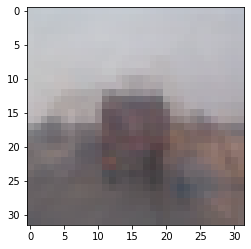

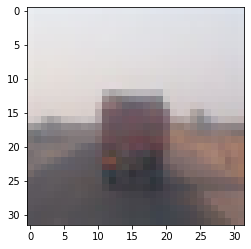

predicted truck
true truck
****************************************************************************************************


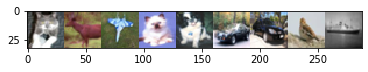

tensor([2.3733e-03, 7.5410e-03, 9.0703e-04, 4.1937e-04, 1.2230e-02, 1.5283e-03,
        8.3271e-03, 9.1007e-03, 9.5757e-01], device='cuda:0',
       dtype=torch.float64)


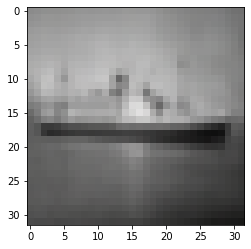

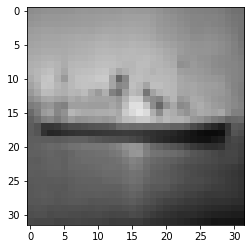

predicted ship
true ship
****************************************************************************************************


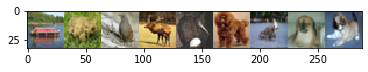

tensor([0.5780, 0.0106, 0.1477, 0.0237, 0.0045, 0.0334, 0.0218, 0.1229, 0.0573],
       device='cuda:0', dtype=torch.float64)


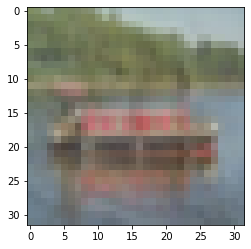

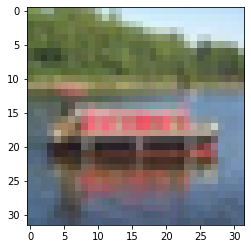

predicted ship
true ship
****************************************************************************************************


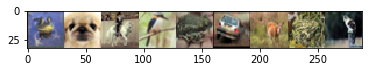

tensor([0.0387, 0.1035, 0.0409, 0.0683, 0.1180, 0.0767, 0.0527, 0.0189, 0.4823],
       device='cuda:0', dtype=torch.float64)


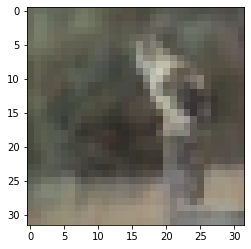

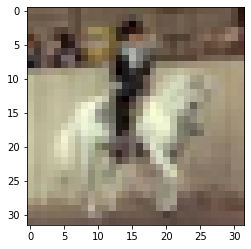

predicted horse
true horse
****************************************************************************************************


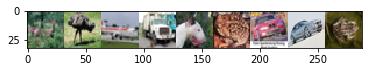

tensor([3.9407e-03, 3.6965e-03, 1.0052e-02, 9.7206e-01, 2.5297e-03, 8.4635e-04,
        3.2984e-03, 2.9003e-03, 6.7606e-04], device='cuda:0',
       dtype=torch.float64)


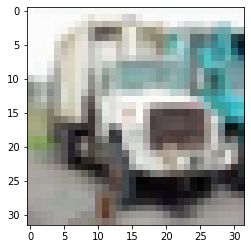

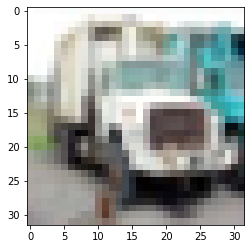

predicted truck
true truck
****************************************************************************************************


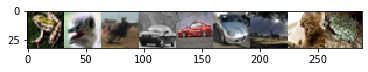

tensor([0.0040, 0.0578, 0.3923, 0.1068, 0.0646, 0.0712, 0.2507, 0.0442, 0.0084],
       device='cuda:0', dtype=torch.float64)


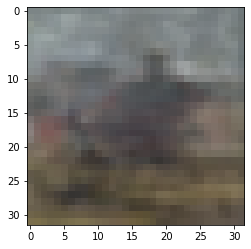

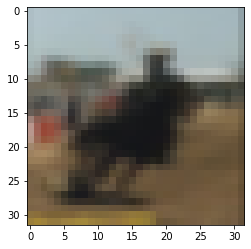

predicted horse
true horse
****************************************************************************************************


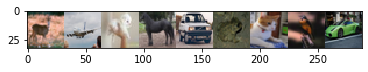

tensor([0.0057, 0.0121, 0.0244, 0.8985, 0.0095, 0.0067, 0.0038, 0.0149, 0.0243],
       device='cuda:0', dtype=torch.float64)


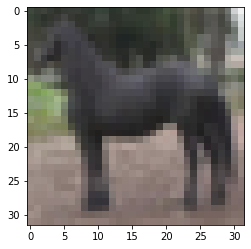

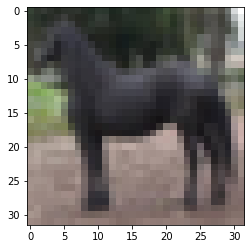

predicted horse
true horse
****************************************************************************************************


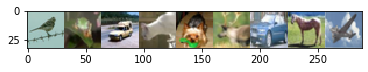

tensor([3.0539e-03, 8.3813e-03, 3.7558e-03, 7.1468e-03, 2.2621e-03, 1.8935e-03,
        8.6933e-04, 9.7180e-01, 8.3692e-04], device='cuda:0',
       dtype=torch.float64)


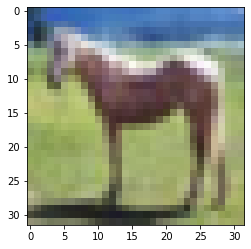

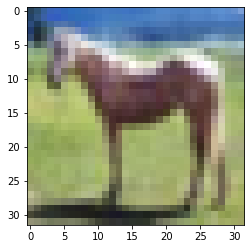

predicted horse
true horse
****************************************************************************************************


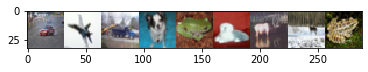

tensor([0.2674, 0.0048, 0.2303, 0.0145, 0.0264, 0.0123, 0.3958, 0.0173, 0.0312],
       device='cuda:0', dtype=torch.float64)


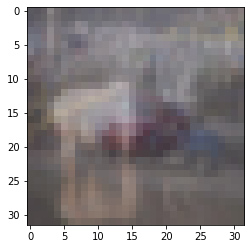

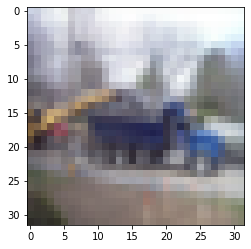

predicted truck
true truck
****************************************************************************************************


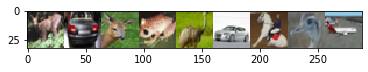

tensor([0.2122, 0.0489, 0.0395, 0.0609, 0.0101, 0.1125, 0.0220, 0.1803, 0.3135],
       device='cuda:0', dtype=torch.float64)


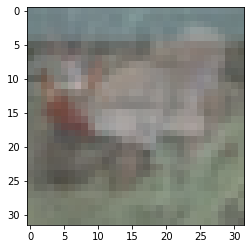

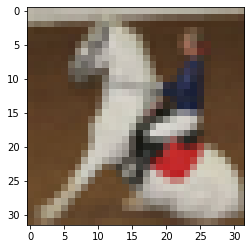

predicted horse
true horse
****************************************************************************************************


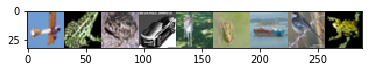

tensor([0.0028, 0.1560, 0.0252, 0.0041, 0.0785, 0.0120, 0.6233, 0.0892, 0.0089],
       device='cuda:0', dtype=torch.float64)


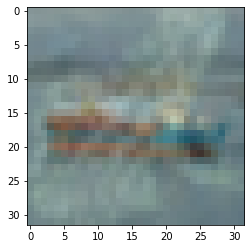

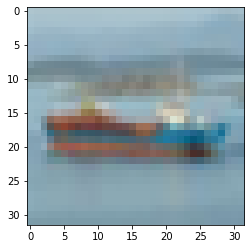

predicted ship
true ship
****************************************************************************************************


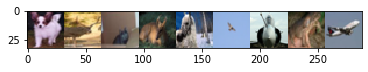

tensor([0.0047, 0.0116, 0.0651, 0.0508, 0.0315, 0.0070, 0.7255, 0.0276, 0.0762],
       device='cuda:0', dtype=torch.float64)


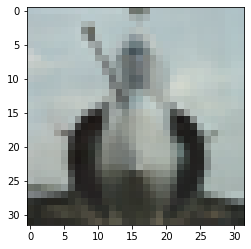

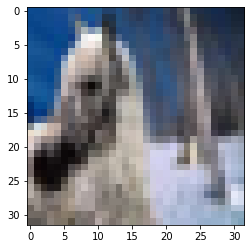

predicted horse
true horse
****************************************************************************************************


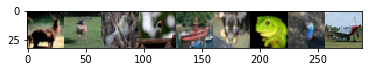

tensor([0.0042, 0.0797, 0.1255, 0.0156, 0.5985, 0.0812, 0.0021, 0.0233, 0.0700],
       device='cuda:0', dtype=torch.float64)


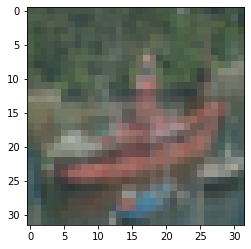

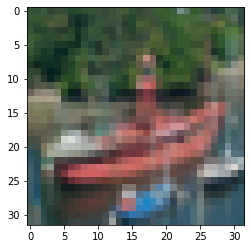

predicted ship
true ship
****************************************************************************************************


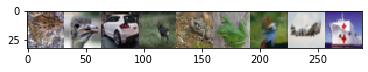

tensor([0.1399, 0.1357, 0.0401, 0.0909, 0.0792, 0.0750, 0.0672, 0.2051, 0.1668],
       device='cuda:0', dtype=torch.float64)


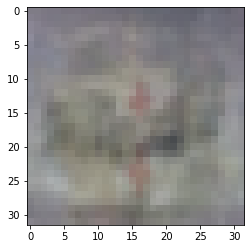

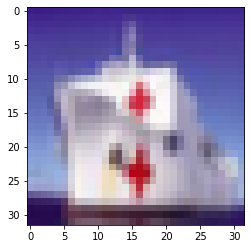

predicted ship
true ship
****************************************************************************************************


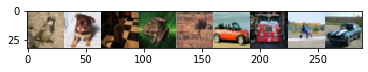

tensor([0.1792, 0.0805, 0.0475, 0.1223, 0.1178, 0.0121, 0.1931, 0.2027, 0.0447],
       device='cuda:0', dtype=torch.float64)


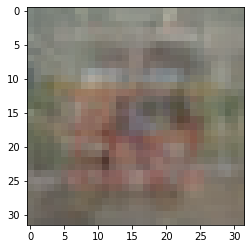

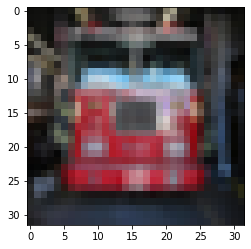

predicted truck
true truck
****************************************************************************************************


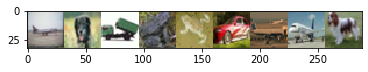

tensor([0.0295, 0.0439, 0.4461, 0.2093, 0.0112, 0.0270, 0.0550, 0.1161, 0.0619],
       device='cuda:0', dtype=torch.float64)


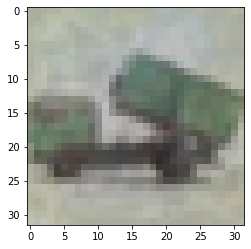

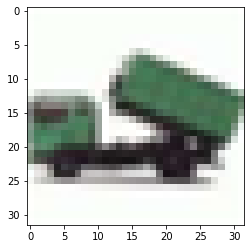

predicted truck
true truck
****************************************************************************************************


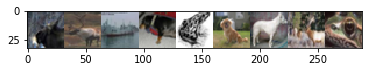

tensor([0.0072, 0.0109, 0.8782, 0.0054, 0.0159, 0.0332, 0.0182, 0.0133, 0.0178],
       device='cuda:0', dtype=torch.float64)


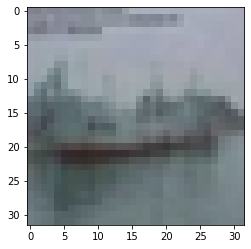

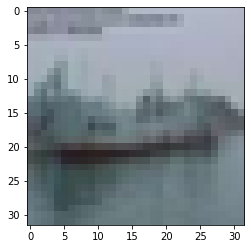

predicted ship
true ship
****************************************************************************************************


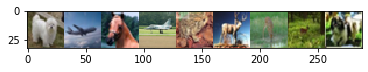

tensor([0.0519, 0.0235, 0.5163, 0.0476, 0.0139, 0.0503, 0.0354, 0.0257, 0.2354],
       device='cuda:0', dtype=torch.float64)


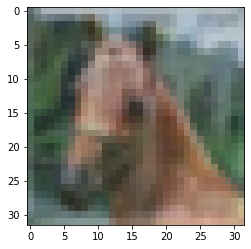

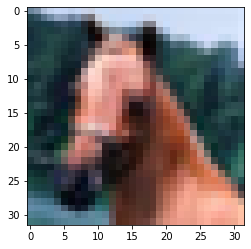

predicted horse
true horse
Accuracy of the network on the 30000 train images: 96 %
total correct 29069
total train set images 30000
focus_true_pred_true 33
focus_false_pred_true 16
focus_true_pred_false 1
focus_false_pred_false 0
argmax_more_than_half 30
argmax_less_than_half 20


In [80]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])
        
        focus = torch.argmax(alphas[j])
      
        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

      flag =0

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
    bg_idx = np.random.randint(0,35000,8)
    fg_idx = np.random.randint(0,15000)
    fg = np.random.randint(0,9)
    fore_idx_test.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    test_images.append(image_list)
    test_label.append(label)

In [0]:
# test_data = MosaicDataset(test_images,test_label,)
# test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

5


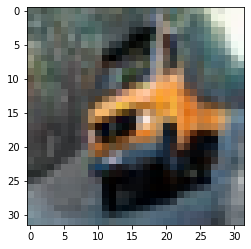

truck


In [83]:
print(fore_idx_test[0])
imshow(test_images[0][fore_idx_test[0]])
print(classes[test_label[0]+7])

****************************************************************************************************


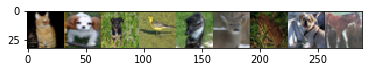

tensor([0.0284, 0.1180, 0.0752, 0.1778, 0.0150, 0.1519, 0.1508, 0.1680, 0.1150],
       device='cuda:0', dtype=torch.float64)


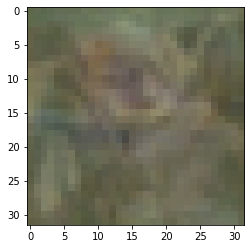

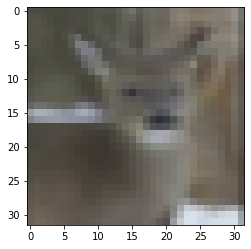

predicted horse
true horse
****************************************************************************************************


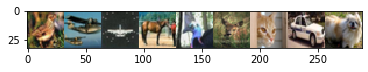

tensor([0.0159, 0.0810, 0.0249, 0.5232, 0.0162, 0.0250, 0.0176, 0.2489, 0.0473],
       device='cuda:0', dtype=torch.float64)


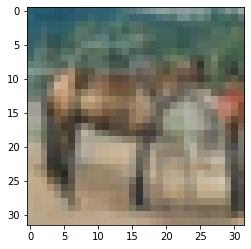

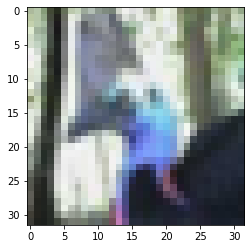

predicted horse
true horse
****************************************************************************************************


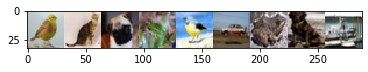

tensor([0.0183, 0.0658, 0.0031, 0.0195, 0.0051, 0.0287, 0.0099, 0.0524, 0.7972],
       device='cuda:0', dtype=torch.float64)


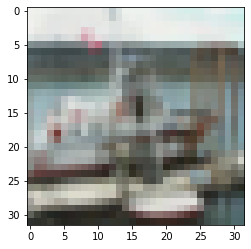

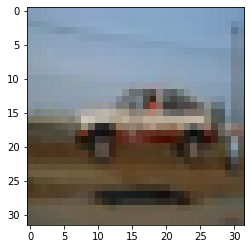

predicted ship
true ship
****************************************************************************************************


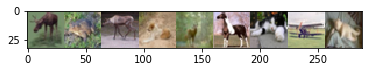

tensor([0.0629, 0.0167, 0.0041, 0.0037, 0.0107, 0.8255, 0.0533, 0.0171, 0.0059],
       device='cuda:0', dtype=torch.float64)


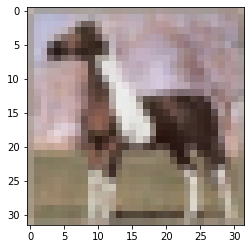

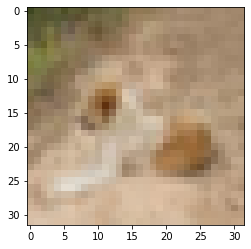

predicted horse
true horse
****************************************************************************************************


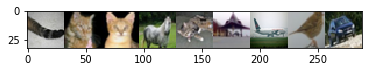

tensor([0.0128, 0.0115, 0.0259, 0.0431, 0.0340, 0.7196, 0.0205, 0.0455, 0.0872],
       device='cuda:0', dtype=torch.float64)


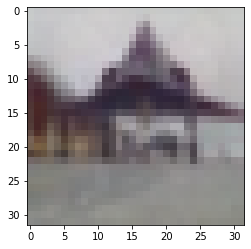

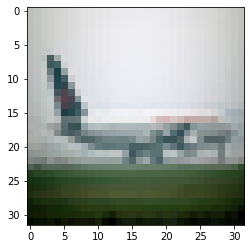

predicted truck
true horse
****************************************************************************************************


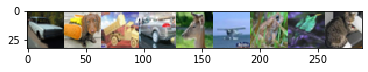

tensor([0.0038, 0.3050, 0.3122, 0.0127, 0.0286, 0.0713, 0.0205, 0.2336, 0.0124],
       device='cuda:0', dtype=torch.float64)


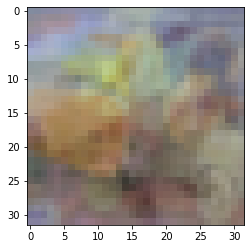

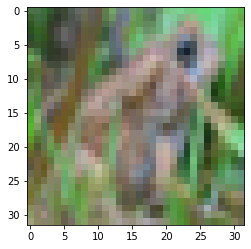

predicted ship
true truck
****************************************************************************************************


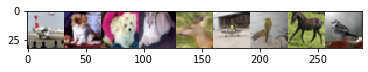

tensor([0.0861, 0.0205, 0.0037, 0.0183, 0.0063, 0.0872, 0.2929, 0.4159, 0.0693],
       device='cuda:0', dtype=torch.float64)


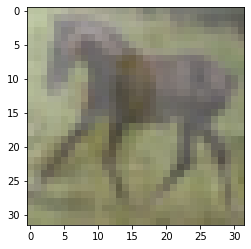

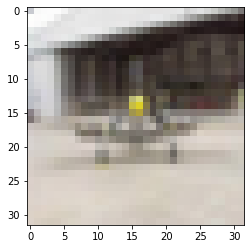

predicted horse
true horse
****************************************************************************************************


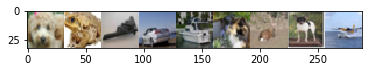

tensor([0.0279, 0.0049, 0.4999, 0.0088, 0.3207, 0.0132, 0.0115, 0.0787, 0.0345],
       device='cuda:0', dtype=torch.float64)


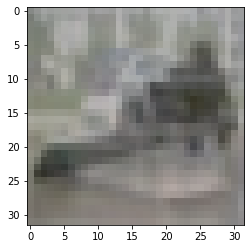

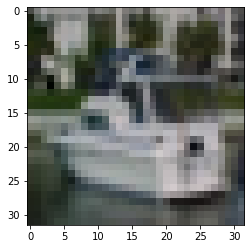

predicted ship
true ship
****************************************************************************************************


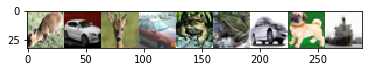

tensor([0.0204, 0.0041, 0.0033, 0.0167, 0.0346, 0.0099, 0.0135, 0.0051, 0.8923],
       device='cuda:0', dtype=torch.float64)


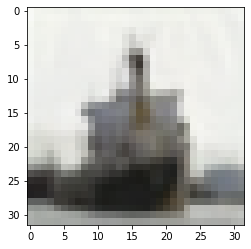

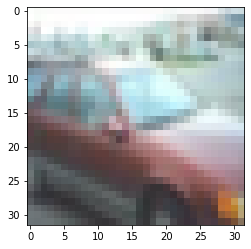

predicted ship
true ship
****************************************************************************************************


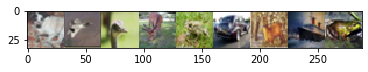

tensor([0.0851, 0.0639, 0.0253, 0.2443, 0.0152, 0.3359, 0.0433, 0.1687, 0.0184],
       device='cuda:0', dtype=torch.float64)


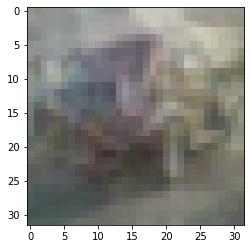

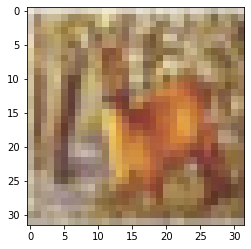

predicted truck
true ship
****************************************************************************************************


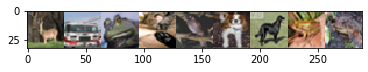

tensor([0.0118, 0.1930, 0.7101, 0.0095, 0.0183, 0.0079, 0.0309, 0.0014, 0.0171],
       device='cuda:0', dtype=torch.float64)


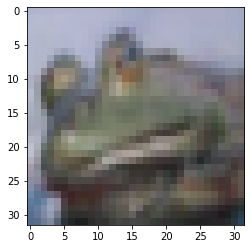

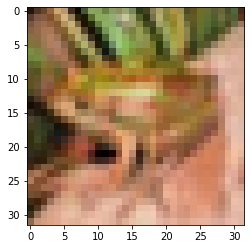

predicted ship
true truck
****************************************************************************************************


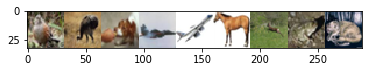

tensor([0.0307, 0.0153, 0.3676, 0.0285, 0.0133, 0.2492, 0.0393, 0.0013, 0.2547],
       device='cuda:0', dtype=torch.float64)


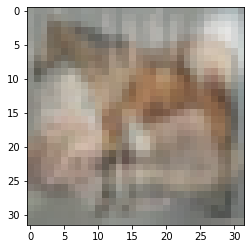

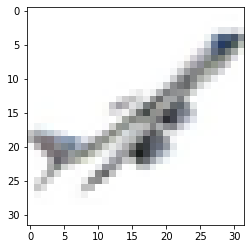

predicted horse
true horse
****************************************************************************************************


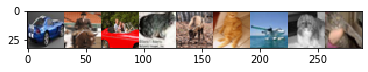

tensor([0.0258, 0.0501, 0.0249, 0.1754, 0.4685, 0.0096, 0.1844, 0.0330, 0.0282],
       device='cuda:0', dtype=torch.float64)


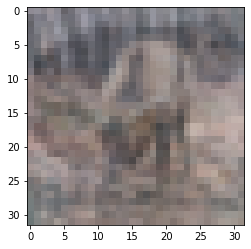

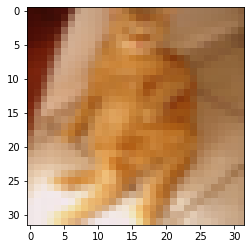

predicted horse
true horse
****************************************************************************************************


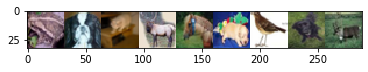

tensor([0.0084, 0.0658, 0.0383, 0.0902, 0.6552, 0.0532, 0.0049, 0.0187, 0.0653],
       device='cuda:0', dtype=torch.float64)


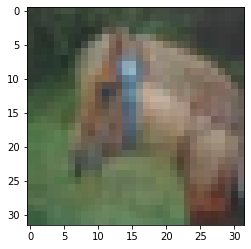

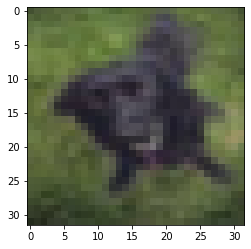

predicted horse
true horse
****************************************************************************************************


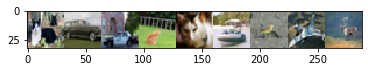

tensor([0.0354, 0.2834, 0.1967, 0.0734, 0.0264, 0.1108, 0.1395, 0.0226, 0.1117],
       device='cuda:0', dtype=torch.float64)


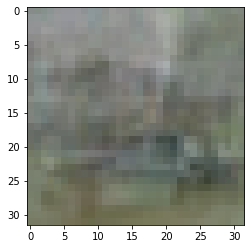

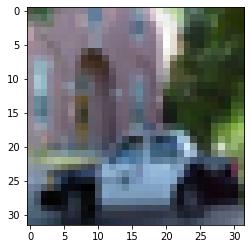

predicted horse
true ship
****************************************************************************************************


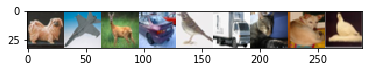

tensor([1.2504e-03, 1.3245e-03, 9.6591e-04, 7.3955e-04, 1.1271e-04, 9.8680e-01,
        6.7555e-03, 5.4726e-04, 1.5080e-03], device='cuda:0',
       dtype=torch.float64)


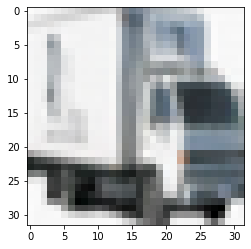

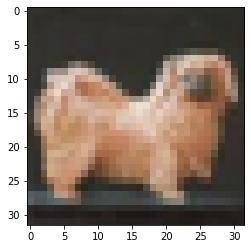

predicted truck
true truck
****************************************************************************************************


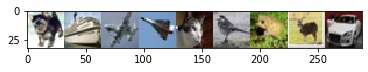

tensor([1.5673e-02, 6.3329e-01, 4.0831e-02, 4.7560e-04, 2.8481e-02, 2.1167e-01,
        9.6080e-03, 3.3689e-02, 2.6285e-02], device='cuda:0',
       dtype=torch.float64)


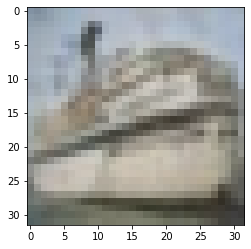

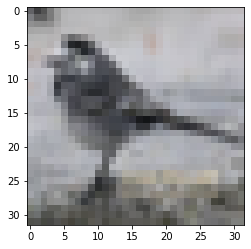

predicted ship
true ship
****************************************************************************************************


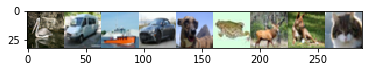

tensor([0.0196, 0.0114, 0.6238, 0.0903, 0.1265, 0.0386, 0.0217, 0.0011, 0.0672],
       device='cuda:0', dtype=torch.float64)


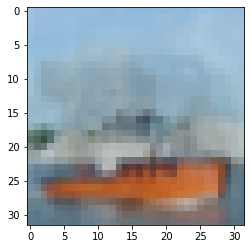

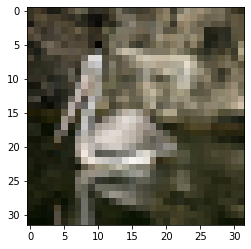

predicted ship
true ship
****************************************************************************************************


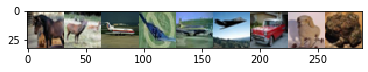

tensor([0.4713, 0.0555, 0.1136, 0.0223, 0.1185, 0.0263, 0.0436, 0.1059, 0.0429],
       device='cuda:0', dtype=torch.float64)


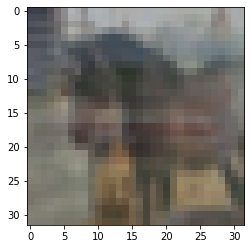

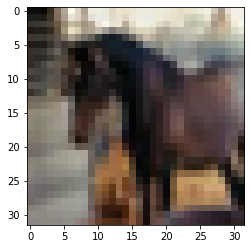

predicted horse
true horse
****************************************************************************************************


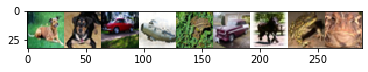

tensor([0.0451, 0.1042, 0.6726, 0.0239, 0.0436, 0.0271, 0.0397, 0.0284, 0.0152],
       device='cuda:0', dtype=torch.float64)


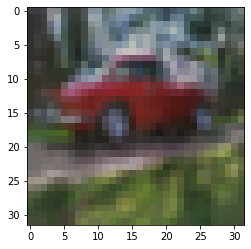

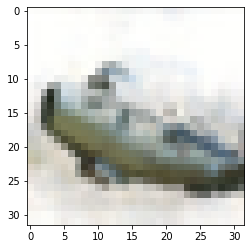

predicted horse
true horse
****************************************************************************************************


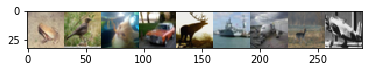

tensor([0.0034, 0.0057, 0.2193, 0.0052, 0.0007, 0.3451, 0.3998, 0.0143, 0.0065],
       device='cuda:0', dtype=torch.float64)


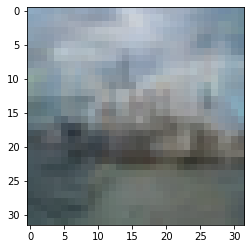

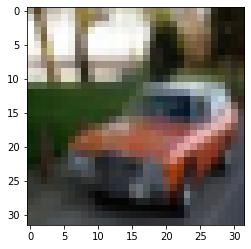

predicted ship
true ship
****************************************************************************************************


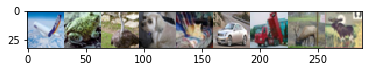

tensor([5.1153e-04, 2.7943e-03, 2.1939e-03, 2.4638e-03, 1.2560e-03, 7.4325e-03,
        9.7352e-01, 4.3254e-03, 5.5016e-03], device='cuda:0',
       dtype=torch.float64)


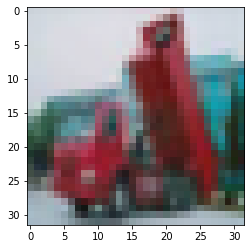

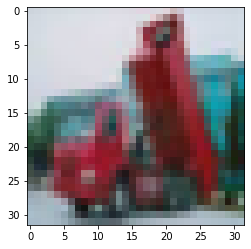

predicted truck
true truck
****************************************************************************************************


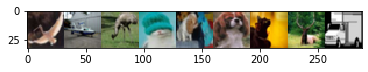

tensor([0.0280, 0.4143, 0.1499, 0.1173, 0.0598, 0.0353, 0.0099, 0.0057, 0.1798],
       device='cuda:0', dtype=torch.float64)


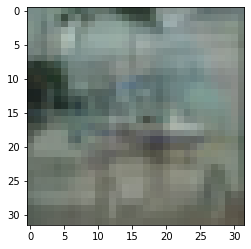

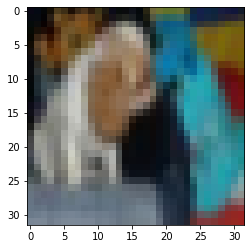

predicted truck
true truck
****************************************************************************************************


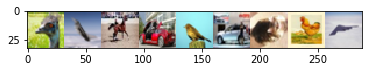

tensor([0.0189, 0.0039, 0.1375, 0.0279, 0.0966, 0.3136, 0.1457, 0.2335, 0.0225],
       device='cuda:0', dtype=torch.float64)


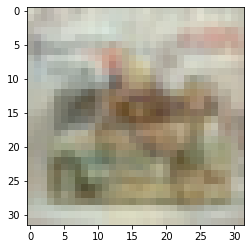

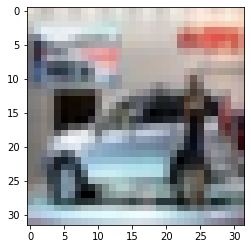

predicted truck
true horse
****************************************************************************************************


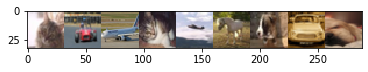

tensor([0.1456, 0.0885, 0.0492, 0.1006, 0.2454, 0.1695, 0.1347, 0.0406, 0.0259],
       device='cuda:0', dtype=torch.float64)


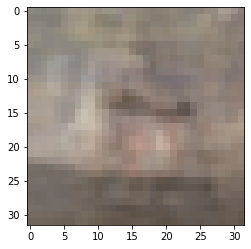

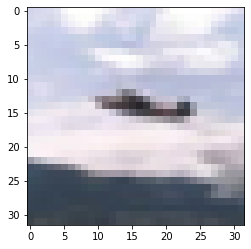

predicted horse
true horse
****************************************************************************************************


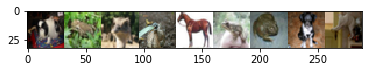

tensor([2.7180e-04, 1.4545e-04, 8.1321e-05, 4.3479e-05, 9.9827e-01, 2.6652e-04,
        9.0927e-05, 2.8860e-05, 7.9764e-04], device='cuda:0',
       dtype=torch.float64)


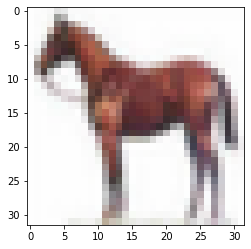

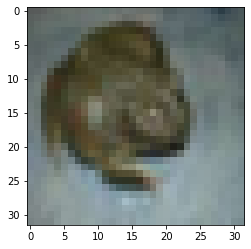

predicted horse
true horse
****************************************************************************************************


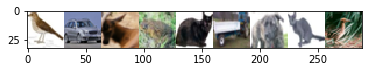

tensor([1.7829e-04, 8.0564e-02, 2.2754e-02, 2.0175e-02, 7.2746e-02, 3.9934e-01,
        2.1593e-01, 4.7825e-03, 1.8352e-01], device='cuda:0',
       dtype=torch.float64)


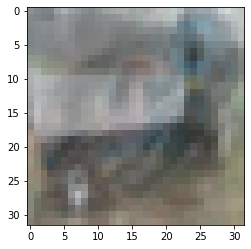

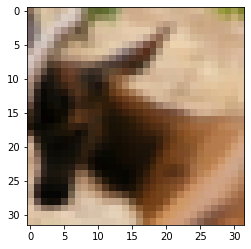

predicted truck
true truck
****************************************************************************************************


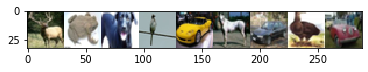

tensor([1.6247e-04, 9.9592e-05, 3.3079e-04, 1.0556e-03, 3.3978e-04, 9.9571e-01,
        8.2365e-04, 2.6446e-04, 1.2110e-03], device='cuda:0',
       dtype=torch.float64)


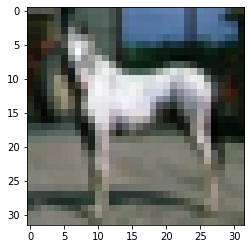

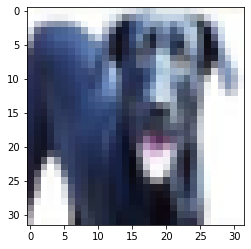

predicted horse
true horse
****************************************************************************************************


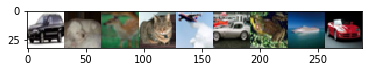

tensor([0.0137, 0.0272, 0.0255, 0.0669, 0.0120, 0.0027, 0.0978, 0.6507, 0.1035],
       device='cuda:0', dtype=torch.float64)


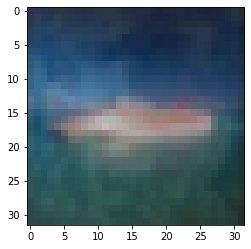

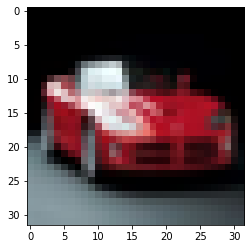

predicted ship
true ship
****************************************************************************************************


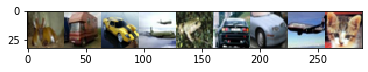

tensor([4.9101e-03, 8.1841e-01, 6.6903e-04, 6.7681e-02, 3.4736e-03, 9.9214e-02,
        1.6040e-03, 3.3473e-03, 6.8748e-04], device='cuda:0',
       dtype=torch.float64)


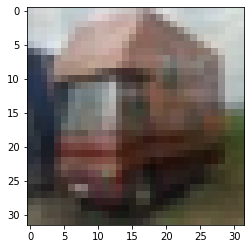

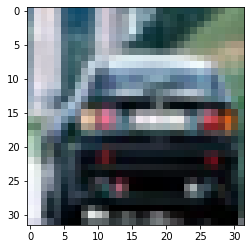

predicted truck
true truck
****************************************************************************************************


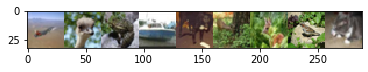

tensor([0.0950, 0.0173, 0.0063, 0.6351, 0.1016, 0.0538, 0.0109, 0.0419, 0.0381],
       device='cuda:0', dtype=torch.float64)


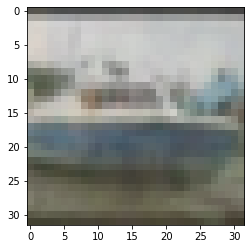

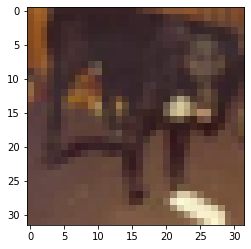

predicted ship
true ship
****************************************************************************************************


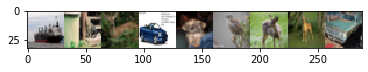

tensor([0.5788, 0.2770, 0.0234, 0.0276, 0.0291, 0.0139, 0.0092, 0.0117, 0.0293],
       device='cuda:0', dtype=torch.float64)


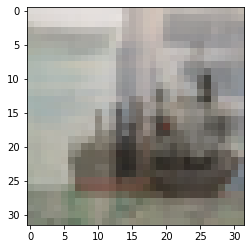

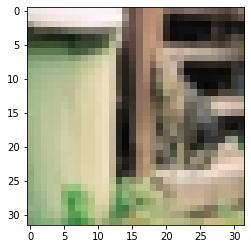

predicted ship
true ship
****************************************************************************************************


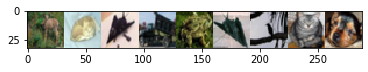

tensor([0.0803, 0.0040, 0.0143, 0.7688, 0.0105, 0.0209, 0.0241, 0.0545, 0.0225],
       device='cuda:0', dtype=torch.float64)


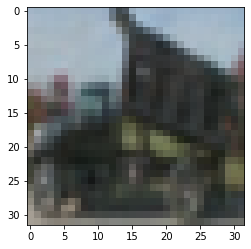

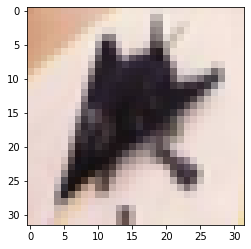

predicted truck
true truck
****************************************************************************************************


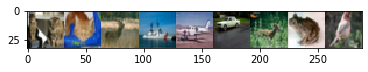

tensor([6.0254e-04, 4.0411e-04, 1.6942e-02, 8.6192e-01, 8.0797e-02, 8.5912e-03,
        2.3365e-02, 1.2273e-03, 6.1509e-03], device='cuda:0',
       dtype=torch.float64)


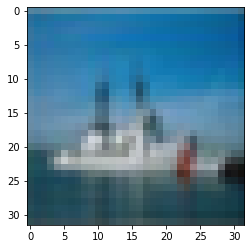

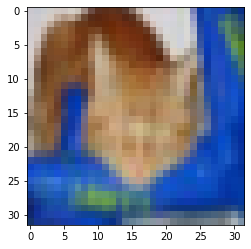

predicted ship
true ship
****************************************************************************************************


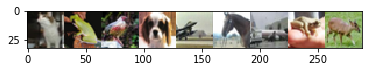

tensor([0.0323, 0.0041, 0.0134, 0.0448, 0.1852, 0.1647, 0.1554, 0.3787, 0.0213],
       device='cuda:0', dtype=torch.float64)


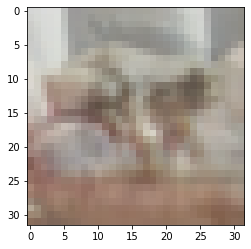

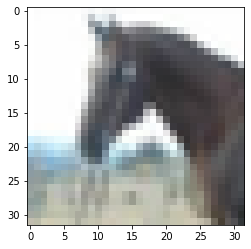

predicted ship
true horse
****************************************************************************************************


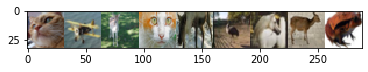

tensor([0.1766, 0.1357, 0.1230, 0.0556, 0.0948, 0.2829, 0.0243, 0.0746, 0.0324],
       device='cuda:0', dtype=torch.float64)


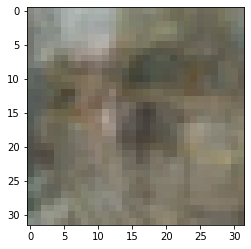

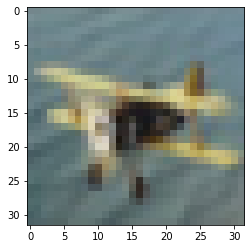

predicted horse
true horse
****************************************************************************************************


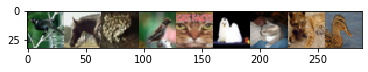

tensor([0.0286, 0.5574, 0.0112, 0.0726, 0.0083, 0.0741, 0.0175, 0.0197, 0.2106],
       device='cuda:0', dtype=torch.float64)


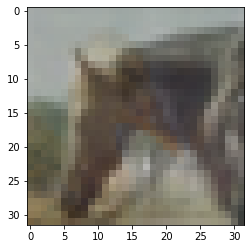

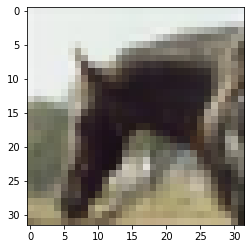

predicted horse
true horse
****************************************************************************************************


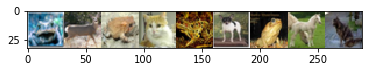

tensor([0.3277, 0.1097, 0.0086, 0.0263, 0.0348, 0.1850, 0.0412, 0.2295, 0.0371],
       device='cuda:0', dtype=torch.float64)


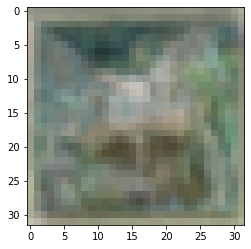

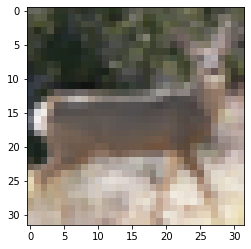

predicted ship
true horse
****************************************************************************************************


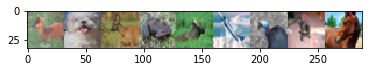

tensor([0.0356, 0.1931, 0.0242, 0.1060, 0.0544, 0.0593, 0.0377, 0.0417, 0.4480],
       device='cuda:0', dtype=torch.float64)


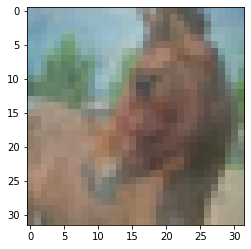

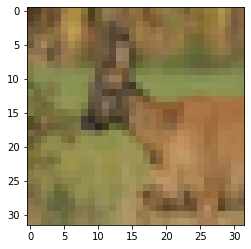

predicted horse
true horse
****************************************************************************************************


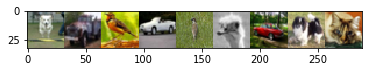

tensor([0.0688, 0.7638, 0.0038, 0.0078, 0.0037, 0.0091, 0.0108, 0.1302, 0.0020],
       device='cuda:0', dtype=torch.float64)


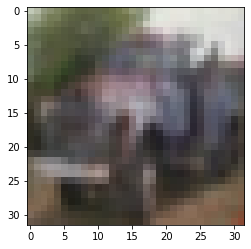

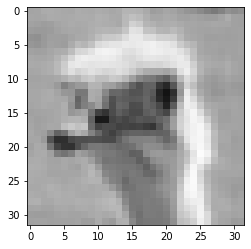

predicted truck
true truck
****************************************************************************************************


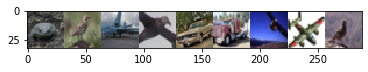

tensor([2.6981e-02, 2.1556e-02, 2.1994e-01, 2.0590e-01, 5.3676e-02, 4.0238e-01,
        2.5078e-03, 1.0224e-04, 6.6951e-02], device='cuda:0',
       dtype=torch.float64)


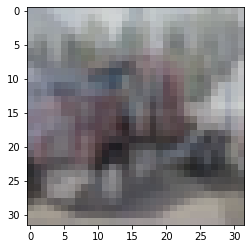

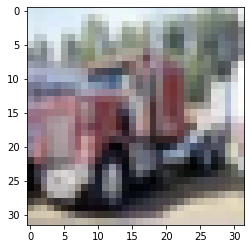

predicted horse
true truck
****************************************************************************************************


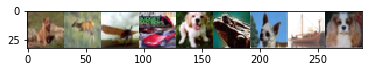

tensor([4.7329e-03, 2.5978e-03, 5.8031e-02, 5.3195e-04, 4.6923e-04, 2.1910e-02,
        1.4462e-02, 8.9564e-01, 1.6239e-03], device='cuda:0',
       dtype=torch.float64)


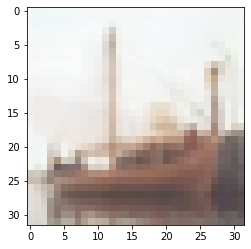

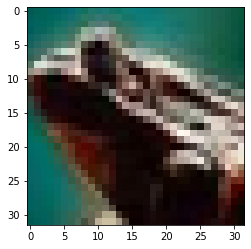

predicted ship
true ship
****************************************************************************************************


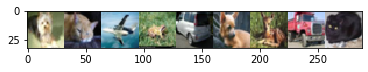

tensor([0.0016, 0.0081, 0.0195, 0.0260, 0.0134, 0.0105, 0.0151, 0.8480, 0.0578],
       device='cuda:0', dtype=torch.float64)


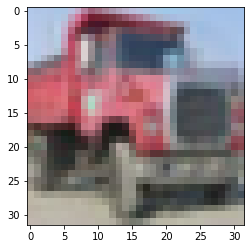

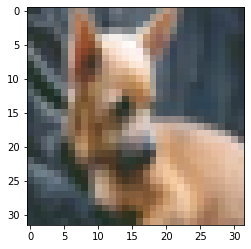

predicted truck
true truck
****************************************************************************************************


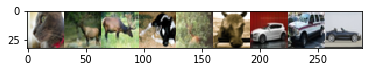

tensor([0.0550, 0.0467, 0.2663, 0.1612, 0.0768, 0.0542, 0.0078, 0.0357, 0.2963],
       device='cuda:0', dtype=torch.float64)


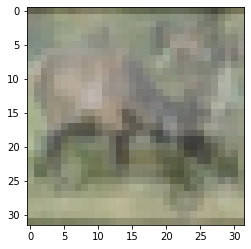

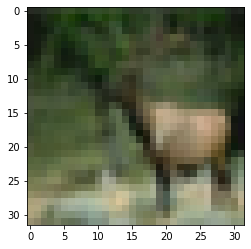

predicted horse
true horse
****************************************************************************************************


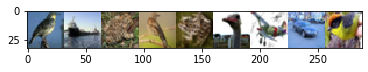

tensor([0.0234, 0.8949, 0.0045, 0.0061, 0.0014, 0.0368, 0.0110, 0.0017, 0.0202],
       device='cuda:0', dtype=torch.float64)


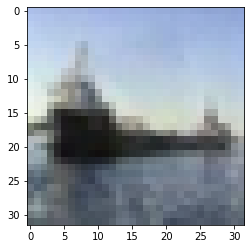

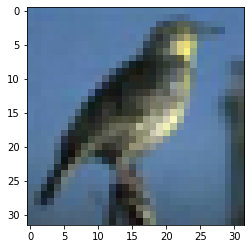

predicted ship
true ship
****************************************************************************************************


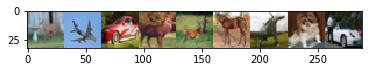

tensor([0.1329, 0.0017, 0.0143, 0.0099, 0.0159, 0.7370, 0.0623, 0.0190, 0.0071],
       device='cuda:0', dtype=torch.float64)


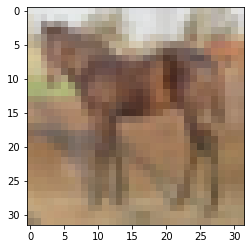

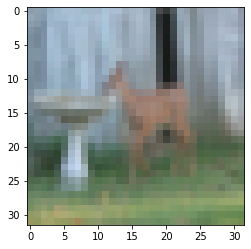

predicted horse
true horse
****************************************************************************************************


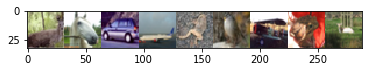

tensor([0.0153, 0.2554, 0.0147, 0.2898, 0.0466, 0.1356, 0.1829, 0.0099, 0.0498],
       device='cuda:0', dtype=torch.float64)


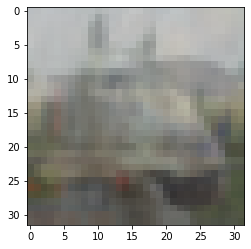

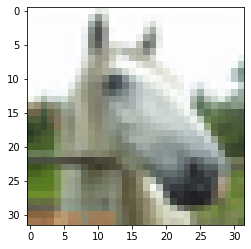

predicted ship
true horse
****************************************************************************************************


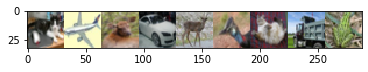

tensor([0.0093, 0.0027, 0.0073, 0.0085, 0.0487, 0.0062, 0.0232, 0.8858, 0.0082],
       device='cuda:0', dtype=torch.float64)


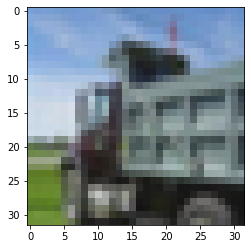

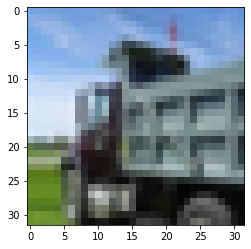

predicted truck
true truck
****************************************************************************************************


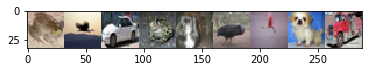

tensor([0.0145, 0.0966, 0.0036, 0.0814, 0.0766, 0.0595, 0.0795, 0.0008, 0.5875],
       device='cuda:0', dtype=torch.float64)


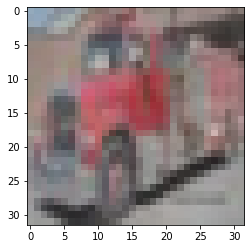

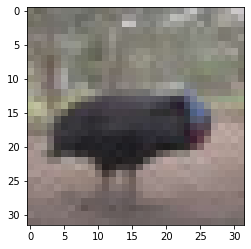

predicted truck
true truck
****************************************************************************************************


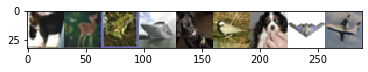

tensor([0.0079, 0.1343, 0.0443, 0.2576, 0.0521, 0.1295, 0.0494, 0.0181, 0.3069],
       device='cuda:0', dtype=torch.float64)


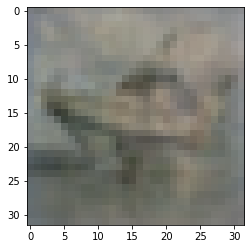

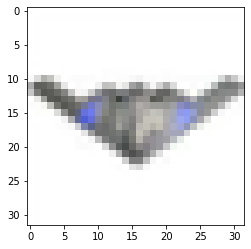

predicted ship
true ship
Accuracy of the network on the 10000 test images: 81 %
total correct 8113
total test set images 10000


In [84]:
correct = 0
total = 0
flag =1
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)


    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx_test[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])

      flag =0


    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
print("total correct", correct)
print("total test set images", total)

In [0]:
a = torch.tensor([0.0071, 0.0466, 0.0025, 0.0282, 0.0140, 0.0067, 0.0145, 0.8750, 0.0055])

In [86]:
print(torch.argmax(a) == 7)
print(batch)

tensor(True)
250


In [87]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 96 %
total correct 29069
total train set images 30000
focus_true_pred_true 23585
focus_false_pred_true 5484
focus_true_pred_false 203
focus_false_pred_false 728
argmax_more_than_half 21522
argmax_less_than_half 8478


In [88]:
bg_idx = np.random.randint(0,35000,8)
fg_idx = np.random.randint(0,15000)
fg = np.random.randint(0,9)
fore_idx_test.append(fg)
image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
test_images.append(image_list)
test_label.append(label)
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 81 %
total correct 8113
total train set images 10000
focus_true_pred_true 6915
focus_false_pred_true 1198
focus_true_pred_false 500
focus_false_pred_false 1387
argmax_more_than_half 6622
argmax_less_than_half 3378


In [0]:
# epoch = 100
# for i in range(epoch):
#   if (i %40) <20:
#     print("What",i)
#   elif (i%40)>20:
#     print("Where",i)